In [1]:
### 모듈 로딩
from PIL import Image
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder 
### ===> Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
import torch.optim as optim

In [2]:
import os
import random
from shutil import copy2

In [3]:
def make_weights(labels, nclasses):
    labels = np.array(labels)  #전체 클래스 받아서 어레이로 받고
    weight_list = []

    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1 / count   #역수 취하기
        weights = [weight] * count  #
        weight_list += weights  #리스트로 바꾸어서 리턴
#전체 받은 샘플에 대해서 그 각각의 가중치를 적용할 수 있다. 
    return weight_list

파일 전처리 함수 만들기

In [4]:
from torchvision.datasets import ImageFolder 

img_root = "./pizza_not_pizza/" # 해당 경로 내에 있는 파일명이 곧 label이 되는 것
train_root="./pizza_not_pizza/train"
test_root="./pizza_not_pizza/test"
validation_root="./pizza_not_pizza/validation"



mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
    transforms.Resize((50,50), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),  
    transforms.Normalize(mean=mean, std=std) # 4. normalized
])

imgDS = ImageFolder(root=img_root, transform=preprocessing)
validDS = ImageFolder(root=validation_root, transform=preprocessing)
testDS = ImageFolder(root=test_root, transform=preprocessing)
trainDS = ImageFolder(root=train_root, transform=preprocessing)


이미지 ds 클래스 확인, 클래스를 idx로 

In [5]:
validDS.classes,validDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [6]:
weights = make_weights(imgDS.targets, len(imgDS.classes))
weights = torch.DoubleTensor(weights)

이미지 샘플러

In [7]:
img_sampler = WeightedRandomSampler(weights, len(weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


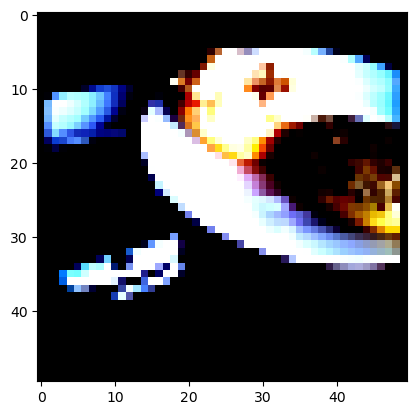

In [8]:
plt.imshow(imgDS[400][0].permute(1,2,0))

In [9]:
batch_size = 32
trainDL = DataLoader(
    trainDS, batch_size=batch_size, drop_last=True,shuffle=True
)
validDL = DataLoader(
    validDS, batch_size=batch_size, drop_last=True,shuffle=True
)

testDL = DataLoader(
    testDS, batch_size=batch_size, drop_last=True,shuffle=True
)

[ 이미지랑 라벨 쪽 형태 보기]

In [10]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [11]:
len(imgDS), len(trainDS)/40, type(trainDL) 

(1966, 40.0, torch.utils.data.dataloader.DataLoader)

In [12]:
### ===>  데이터 확인하기 (1)
### X_train : torch.Size([32, 3, 32, 32]) [배치사이즈, 채널, 높이, 너비]
### Y_train : torch.Size([32]) [배치사이즈] 즉, 32개 이미지에 대한 라벨
for (X_train, y_train) in trainDL:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    

X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
X_train: t

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels =3, out_channels = 8, kernel_size = 3, padding = 1) 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(12*12*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2) 
        
    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x)
        x = self.pool(x) 
        x = self.conv2(x) 
        x = F.relu(x)
        x = self.pool(x) 
        
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [14]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001) #epoch마다 학습률을 0.001씩 줄임

criterion = nn.CrossEntropyLoss() 
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [15]:
# CNN 모델 학습 진행 함수
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
           
        output = model(image)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [16]:
### 검증 validation 진행 함수 
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            # print(image, label)
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
# CNN 학습
EPOCHS =100

for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model,trainDL, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, testDL)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

Train Epoch: 1 [0]	Train Loss: 0.683422

[EPOCH: 1], 	Test Loss: 0.0200, 	Test Accuracy: 62.65 % 

Train Epoch: 2 [0]	Train Loss: 0.645090

[EPOCH: 2], 	Test Loss: 0.0188, 	Test Accuracy: 65.66 % 

Train Epoch: 3 [0]	Train Loss: 0.637201

[EPOCH: 3], 	Test Loss: 0.0183, 	Test Accuracy: 68.07 % 

Train Epoch: 4 [0]	Train Loss: 0.571014

[EPOCH: 4], 	Test Loss: 0.0179, 	Test Accuracy: 68.07 % 

Train Epoch: 5 [0]	Train Loss: 0.662011

[EPOCH: 5], 	Test Loss: 0.0174, 	Test Accuracy: 71.08 % 

Train Epoch: 6 [0]	Train Loss: 0.541860

[EPOCH: 6], 	Test Loss: 0.0174, 	Test Accuracy: 69.88 % 

Train Epoch: 7 [0]	Train Loss: 0.611150

[EPOCH: 7], 	Test Loss: 0.0182, 	Test Accuracy: 69.28 % 

Train Epoch: 8 [0]	Train Loss: 0.490077

[EPOCH: 8], 	Test Loss: 0.0179, 	Test Accuracy: 67.47 % 

Train Epoch: 9 [0]	Train Loss: 0.463202

[EPOCH: 9], 	Test Loss: 0.0176, 	Test Accuracy: 68.67 % 

Train Epoch: 10 [0]	Train Loss: 0.748399

[EPOCH: 10], 	Test Loss: 0.0178, 	Test Accuracy: 66.87 % 

Train Ep

### ALEXNET 사용

In [18]:
from torchvision.models import resnet18,ResNet18_Weights,AlexNet

#데이터 모델 학습 준비 
model = AlexNet(num_classes=2) # 클래스 수에 맞춰 출력 레이어 수정
model = model.to(DEVICE)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 데이터 재설정 

ALEXPREPRO = transforms.Compose([
    transforms.Resize(256),  # 이미지를 리사이징
    transforms.CenterCrop(224),  # 이미지 중심부 자르기
    transforms.ToTensor()
])

# 데이터셋과 데이터로더 생성
ALEXvalidDS = ImageFolder(root=validation_root, transform=ALEXPREPRO)
ALEXtestDS = ImageFolder(root=test_root, transform=ALEXPREPRO)
ALEXtrainDS = ImageFolder(root=train_root, transform=ALEXPREPRO)

ALEXtrainDL = DataLoader(ALEXtrainDS, batch_size=32, shuffle=True)
ALEXvalidDL = DataLoader(ALEXvalidDS, batch_size=32, shuffle=False)
ALEXtestDL = DataLoader(ALEXtestDS, batch_size=32, shuffle=False)







